In [2]:
#@title Installation and Imports

import numpy as np
import networkx as nx
import scipy.linalg
import torch

In [3]:
#@title Many-body MPNNConv Layer

import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.nn.init as init
from torch_geometric.nn import ChebConv
from torch_geometric.utils import to_networkx, to_scipy_sparse_matrix, add_self_loops, get_laplacian, to_dense_adj

class ManyBodyMPNNConv(nn.Module):
    def __init__(self, in_channels, out_channels, max_order, edge_feature_dim, K=3):
        super(ManyBodyMPNNConv, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.max_order = max_order
        self.K = K
        self.U, self.V = self.precompute_motif_eigenvectors(max_order + 1)

        self.W_cheb = nn.ParameterList([nn.Parameter(torch.randn(out_channels, in_channels, K)) for _ in range(max_order)])
        self.W_cheb_motif = nn.ParameterList([nn.Parameter(torch.randn(in_channels, k, K)) for k in range(2, max_order+1)])
        self.W_msg = nn.Linear(in_channels, out_channels)

    @staticmethod
    def precompute_motif_eigenvectors(n):
        U, V = {}, {}
        for i in range(2, n + 1):
            motif_graph = nx.star_graph(i - 1)
            laplacian_matrix = nx.laplacian_matrix(motif_graph).toarray()
            eigenvalues, eigenvectors = scipy.linalg.eigh(laplacian_matrix)
            U[i] = torch.linalg.inv(torch.tensor(eigenvectors, dtype=torch.float))
            V[i] = torch.tensor(eigenvalues, dtype=torch.float)
        return U, V

    def chebyshev_expansion(self, x, K):
        T_0, T_1 = torch.ones_like(x), x
        expansion = [T_0, T_1]
        for k in range(2, K + 1):
            T_k = 2 * x * T_1 - T_0
            expansion.append(T_k)
            T_0, T_1 = T_1, T_k
        return torch.stack(expansion, dim=-1)

    def apply_chebyshev(self, L, X, K):
        X_0 = X
        X_1 = torch.matmul(L, X)
        result = self.W_cheb[0][:, :, 0].unsqueeze(1) * X_0 + self.W_cheb[0][:, :, 1].unsqueeze(1) * X_1
        for k in range(2, K):
            X_k = 2 * torch.matmul(L, X_1) - X_0
            result += self.W_cheb[0][:, :, k].unsqueeze(1) * X_k
            X_0, X_1 = X_1, X_k
        return result

    def higher_order_interaction(self, H, edge_index):

        # Initialize the output feature matrix
        Y = torch.zeros_like(H)

        # Iterate through orders from 2 to max_order
        for order in range(2, self.max_order + 1):
            # Retrieve the precomputed eigenvectors U_k and eigenvalues for the current order
            U_k = self.U[order].to(H.device)
            lambda_k = self.V[order].to(H.device)

            # Scale the eigenvalues for Chebyshev expansion and perform the expansion
            scaled_eigenvalues = 2 * lambda_k / lambda_k.max() - 1
            T_k = self.chebyshev_expansion(scaled_eigenvalues, self.K)

            # Apply the filter defined by the Chebyshev expansion
            for i in range(self.K):
                # Chebyshev polynomial of degree i on the Laplacian, weighted by W_cheb
                filter_response = torch.matmul(U_k, torch.matmul(torch.diag(T_k[:, i]), U_k.t()))
                weights = self.W_cheb_motif[order-2][:, :, i]  # Assuming this needs to align with `result`
                result = torch.einsum("ni,ik->ni", H, torch.matmul(weights, filter_response.t()))
                Y += result

        return Y

    def forward(self, H, edge_index, edge_features=None):
        # Compute Laplacian
        edge_index, edge_weight = add_self_loops(edge_index, num_nodes=H.size(0))
        edge_weight = torch.ones(edge_index.size(1), device=H.device)
        L = get_laplacian(edge_index, edge_weight, normalization='sym', dtype=torch.float, num_nodes=H.size(0))

        L_dense = to_dense_adj(L[0], edge_attr=L[1], max_num_nodes=H.size(0)).squeeze(0)
        L_scaled = 2 * L_dense - torch.eye(L_dense.size(0), device=H.device)

        # Direct interaction via a custom Chebyshev operation
        X_2 = self.apply_chebyshev(L_scaled, H, self.K)
        # Higher-order interactions
        m = self.higher_order_interaction(H, edge_index)
        # Combine direct and higher-order interactions
        H_next = X_2.transpose(0, 1).sum(-1) + self.W_msg(m)
        return H_next

    def __initialize_weights(self):
        for w in self.W_cheb:
            init.kaiming_uniform_(w, a=np.sqrt(5))
        for w in self.W_cheb_motif:
            init.kaiming_uniform_(w, a=np.sqrt(5))


# Dummy data to illustrate usage
num_nodes = 10
in_channels = 4
out_channels = 12
max_order = 3
edge_feature_dim = 1
batch_size = 2

# Instantiate the layer with the learnable_ricci set to True or False based on your setup
layer = ManyBodyMPNNConv(in_channels, out_channels, max_order, edge_feature_dim)

# Dummy node feature matrix
H = torch.randn(num_nodes, in_channels)

# Generate a dummy sparse edge index for a fully-connected graph for simplicity
edge_index = torch.combinations(torch.arange(num_nodes), 2).t()

# Simulate edge features if needed
edge_features = torch.randint(0, 10, (edge_index.size(1), edge_feature_dim)).to(torch.float32)

# Adapt the model call to the new API. Note: Adjust num_nodes if batching logic is different.
H_next = layer(H, edge_index, edge_features=edge_features)

print("Input dimensions:", H.shape)
print("Output dimensions:", H_next.shape)

Input dimensions: torch.Size([10, 4])
Output dimensions: torch.Size([10, 12])


To validate Theorem 4.1 using synthetic datasets and GCN models, we'll perform experiments that track the sensitivity of node features in a GCN to the information contained at other nodes at various distances / commute time.

Matplotlib created a temporary cache directory at /tmp/matplotlib-c99rp0ya because the default path (/scratch-ssd/oatml/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


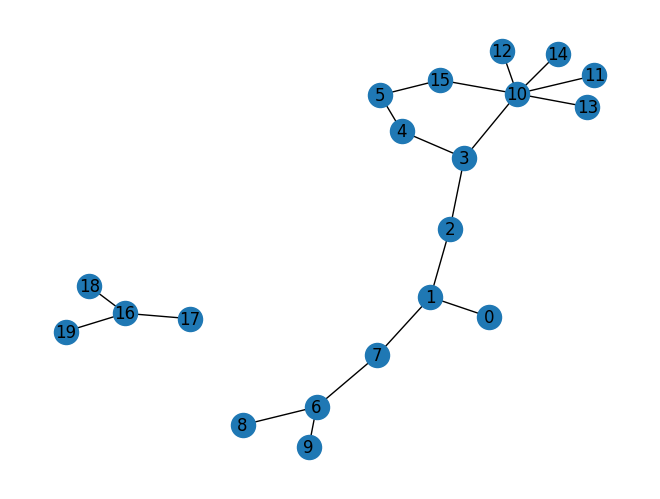

In [4]:
#@title Example Star Graphs with Distorted Structures (Negative Ricci Curvature)
import networkx as nx
import matplotlib.pyplot as plt

# Helper function to create a star-like structure
def create_star(center, leaf_nodes):
    star = nx.Graph()
    for leaf in leaf_nodes:
        star.add_edge(center, leaf)
    return star

# Main function to generate a graph that resembles the attached image
def generate_custom_graph():
    # Create a base chain graph
    chain = nx.path_graph(6)

    # Create branches as star graphs
    branch1 = create_star(1, [7, 8, 9])  # First branch
    branch2 = create_star(3, [10, 11, 12, 13, 14])  # Second branch
    branch3 = create_star(5, [15, 16, 17])  # Third branch

    # Combine the branches with the main chain graph
    G = nx.disjoint_union(chain, branch1)
    G = nx.disjoint_union(G, branch2)
    G = nx.disjoint_union(G, branch3)

    # Now we need to manually add edges between the main chain and the branches
    G.add_edge(1, 7)
    G.add_edge(3, 10)
    G.add_edge(5, 15)

    return G

# Generate the graph
custom_graph = generate_custom_graph()

# Draw the graph
nx.draw(custom_graph, with_labels=True)
plt.show()

In [5]:
# @title Synthetic Dataset Generation (ZINC star graphs)
import torch
from torch_geometric.data import Data
import networkx as nx
import numpy as np
from itertools import combinations
from scipy.sparse.csgraph import connected_components
from scipy.sparse import csr_matrix

def generate_large_star_graph(base_size, branches_per_node):
    G = nx.Graph()

    # Create the base path (spine of the star)
    base_nodes = list(range(base_size))
    G.add_nodes_from(base_nodes)
    for i in range(len(base_nodes) - 1):
        G.add_edge(base_nodes[i], base_nodes[i + 1])

    # Generate branches and attach them to the spine nodes
    leaf_counter = base_size
    for spine_node in base_nodes:
        for _ in range(branches_per_node):
            G.add_node(leaf_counter)
            G.add_edge(spine_node, leaf_counter)
            leaf_counter += 1

    # Convert to edge_index format for PyTorch Geometric
    edge_index = torch.tensor(list(G.edges())).t().contiguous()
    return edge_index

# Function to generate synthetic ZINC datasets with large star graph structure
def generate_synthetic_zinc_star_graphs(num_graphs, base_size, branches_per_node, num_features, num_edge_features):
    graphs = []
    for _ in range(num_graphs):
        edge_indices = generate_large_star_graph(base_size, branches_per_node)
        num_nodes = base_size + branches_per_node * base_size
        node_features = torch.randn((num_nodes, num_features))
        edge_features = torch.randn((edge_indices.size(1), num_edge_features))
        y = torch.randn((1,))  # Placeholder target value

        data = Data(x=node_features, edge_index=edge_indices, edge_attr=edge_features, y=y)
        graphs.append(data)
    return graphs

# Example usage:
base_size = 200  # Increase base size for larger graph
branches_per_node = 4  # Increase branches per node
num_features = 8 # Increase the dimensionality of node features
num_edge_features = 2  # Increase the dimensionality of edge features
num_graphs = 1

large_synthetic_zinc_star_graphs = generate_synthetic_zinc_star_graphs(
    num_graphs, base_size, branches_per_node, num_features, num_edge_features
)
# Function to plot the histogram of pairwise commute times for a given graph
def plot_commute_times_histogram(graph, num_nodes):
    # Convert the edge index to a NetworkX graph for easier manipulation
    G = nx.Graph()
    G.add_edges_from(graph.edge_index.t().numpy())

    # Calculate commute times for all pairs of nodes
    commute_times = {}
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            _, commute_time = simulate_random_walk(G, i, j)
            commute_times[(i,j)] = commute_time

    # Plot the histogram of commute times
    plt.hist(list(commute_times.values()), bins=20)
    plt.xlabel('Commute Time')
    plt.ylabel('Frequency')
    plt.title('Histogram of Pairwise Commute Times')
    plt.show()

    return commute_times

# Select one graph to illustrate
# commute_times = plot_commute_times_histogram(large_synthetic_zinc_star_graphs[0], num_nodes=base_size + branches_per_node)

In [19]:
#@title Many-Body MPNN, GCN, GraphSage, ChebNet Models
import torch
import torch.nn.functional as F
from torch.nn import ModuleList, BatchNorm1d, Linear
from torch_geometric.nn import (
    ChebConv,
    GCNConv,
    SAGEConv,
    GatedGraphConv,
    global_mean_pool,
)


class BaseGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, conv_layer_type, dropout=0.5, *args, **kwargs):
        super(BaseGNN, self).__init__()
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        self.dropout = dropout
        self.saved_grads = {}  # To store gradients

        # Initialize convolutional and batch norm layers
        self.convs.append(conv_layer_type(in_channels, hidden_channels, *args, **kwargs))
        self.bns.append(BatchNorm1d(hidden_channels))
        for _ in range(1, num_layers):
            self.convs.append(conv_layer_type(hidden_channels, hidden_channels, *args, **kwargs))
            self.bns.append(BatchNorm1d(hidden_channels))

        self.lin1 = Linear(hidden_channels, out_channels)

        self.__initialize_weights()
        # Register backward hooks for all convolutional layers
        for idx, conv in enumerate(self.convs):
            conv.register_backward_hook(self.__make_hook(f'conv_{idx}'))

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        for i, (conv, bn) in enumerate(zip(self.convs, self.bns)):
            x = conv(x, edge_index)
            x = bn(x)
            x = F.leaky_relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = global_mean_pool(x, batch)
        x = self.lin1(x)
        return x

    def __initialize_weights(self):
        for conv in self.convs:
            if hasattr(conv, 'weight'):
                nn.init.kaiming_uniform_(conv.weight, nonlinearity='leaky_relu')
            if hasattr(conv, 'bias') and conv.bias is not None:
                nn.init.zeros_(conv.bias)
        nn.init.kaiming_uniform_(self.lin1.weight, nonlinearity='leaky_relu')
        nn.init.zeros_(self.lin1.bias)

    def __make_hook(self, layer_name):
        def hook(module, grad_input, grad_output):
            self.saved_grads[layer_name] = grad_output[0].detach()
        return hook

    def get_gradients(self, layer_name):
        """Retrieve the saved gradients by layer name."""
        return self.saved_grads.get(layer_name, None)


class ManyBodyMPNN(BaseGNN):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, max_order, edge_feature_dim, K=3, dropout=0.5):
        super(ManyBodyMPNN, self).__init__(in_channels, hidden_channels, out_channels,
                                  num_layers, ManyBodyMPNNConv, dropout, max_order, edge_feature_dim, K)

class GCN(BaseGNN):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, dropout=0.5):
        super(GCN, self).__init__(in_channels, hidden_channels, out_channels, num_layers, GCNConv, dropout)

class ChebNet(BaseGNN):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, K, dropout=0.5):
        super(ChebNet, self).__init__(in_channels, hidden_channels, out_channels, num_layers, ChebConv, dropout, K)


In [247]:
#@title Define Training Loops and Parameters
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.utils import add_self_loops
from scipy.sparse.csgraph import shortest_path
from tqdm.auto import tqdm
import networkx as nx
import numpy as np

from collections import defaultdict

def compute_J(h_v_m, h_u_m, h_v_k, h_u_k, dv, du):
    # Ensure gradient computation is enabled for the scope of this function
    J = torch.max((1 / dv) * (h_v_m / h_v_k) - (1 / torch.sqrt(dv * du)) * (h_v_m / h_u_k))
    return J

def compute_aggregate_J(model, num_of_layers, node_group, degrees):
    """
    Computes the aggregate J values (average and maximum) for a group of nodes.

    model: The trained GNN model.
    num_of_layers: Number of layers in the model.
    node_group: List of node indices in the group.
    degrees: Degrees of the nodes in the group.
    """
    # Store all J values for combinations within the group
    model.eval()
    J_values = {}

    # Iterate over all pairs within the group to compute pairwise J
    for i in range(len(node_group)):
        for j in range(i + 1, len(node_group)):
            u, v = node_group[i], node_group[j]
            du, dv = degrees[i], degrees[j]

            h_m_grad = model.get_gradients(f"conv_{num_of_layers-1}")
            h_v_m_grad, h_u_m_grad = h_m_grad[v], h_m_grad[u]

            J_values[(u,v)] = []
            
            for k in range(num_of_layers-1):  # Exclude the last layer for comparison
                h_k_grad = model.get_gradients(f"conv_{k}")
                h_v_k_grad, h_u_k_grad = h_k_grad[v], h_k_grad[u]
    
                # Compute J using the explicitly computed gradients
                J = compute_J(h_v_m_grad, h_u_m_grad, h_v_k_grad, h_u_k_grad, 
                              torch.tensor(dv, dtype=torch.float32), 
                              torch.tensor(du, dtype=torch.float32))
                J_values[(u,v)].append(J.item())

    return J_values

def simulate_random_walk(graph, node_a, node_b, num_simulations=100):
    """
    Simulate a random walk to calculate the access and commute times
    between two nodes in a graph.
    """
    access_times = []
    for _ in range(num_simulations):
        current_node = node_a
        steps_to_reach_b = 0
        reached_b = False
        while not reached_b:
            neighbors = list(graph.neighbors(current_node))
            current_node = np.random.choice(neighbors)
            steps_to_reach_b += 1
            if current_node == node_b and not reached_b:
                reached_b = True
                access_times.append(steps_to_reach_b)
    return np.mean(access_times)

def run_experiments(model_name, model, dataset, device, num_of_layers, layer_width, num_epochs=10):
    data = dataset.to(device)  # assuming dataset is a Data object
    model.to(device)
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    J_statistics = defaultdict(dict)

    for epoch in tqdm(range(num_epochs), desc=f"Training Epochs for {model_name}"):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = F.mse_loss(out.squeeze(), data.y)
        loss.backward()
        optimizer.step()

    # After training, we compute the J quantity

    # Select some pairs of nodes: (for better computational efficiency on estimating commute time)
    # node_pairs_with_neighbors = [
    #     [0, 1, 5, 6],     # Spine nodes at the beginning have 5 and 6 neighbors, respectively
    #     [198, 199, 6, 5], # Spine nodes at the end have 6 and 5 neighbors, respectively
    #     [50, 70, 6, 6],   # Middle spine nodes, both have 6 neighbors
    #     [100, 125, 6, 6], # Another pair of middle spine nodes, both have 6 neighbors
    #     [0, 199, 5, 5],   # First and last spine nodes
    #     [10, 190, 6, 6],  # Spine nodes slightly inwards from the ends
    #     [200, 201, 1, 1], # Branch nodes from the same spine node have 1 neighbor each
    #     [202, 205, 1, 1], # Branch nodes from adjacent spine nodes have 1 neighbor each
    #     [0, 200, 5, 1],   # Direct connection between a spine node and its branch
    #     [199, 998, 5, 1]  # Direct connection from the other end of the spine to one of its branches
    # ]

    node_groups = [
        # 3-Node Interactions
        [0, 200, 201],  # Central node 0; branches 200, 201
        [4, 216, 217],  # Central node 4; branches 216, 217
        [10, 240, 241],  # Central node 10; branches 240, 241
        [15, 260, 261],  # Central node 15; branches 260, 261
        
        # 4-Node Interactions
        [1, 2, 204, 208],  # Central nodes 1 and 2; branches 204 (from 1) and 208 (from 2)
        [3, 7, 212, 228],  # Central nodes 3 and 7; branches 212 (from 3) and 228 (from 7)
        [11, 12, 244, 248],  # Central nodes 11 and 12; branches 244 (from 11) and 248 (from 12)
        [16, 17, 264, 268],  # Central nodes 16 and 17; branches 264 (from 16) and 268 (from 17)
        
        # 5-Node Interactions
        [5, 220, 221, 222, 223],  # Central node 5; branches 220, 221, 222, 223
        [6, 224, 225, 226, 227],  # Central node 6; branches 224, 225, 226, 227
        [18, 272, 273, 274, 275],  # Central node 18; branches 272, 273, 274, 275
        [19, 276, 277, 278, 279],  # Central node 19; branches 276, 277, 278, 279
    ]
    
    degrees = [
        # 3-Node Interaction degrees
        [base_size, 1, 1],
        [base_size, 1, 1],
        [base_size, 1, 1],
        [base_size, 1, 1],
        
        # 4-Node Interaction degrees
        [base_size, base_size, 1, 1],
        [base_size, base_size, 1, 1],
        [base_size, base_size, 1, 1],
        [base_size, base_size, 1, 1],
        
        # 5-Node Interaction degrees
        [base_size, 1, 1, 1, 1],
        [base_size, 1, 1, 1, 1],
        [base_size, 1, 1, 1, 1],
        [base_size, 1, 1, 1, 1],
    ]


    for nodes, degs in zip(node_groups, degrees):
        J_values = compute_aggregate_J(model, num_of_layers, nodes, degs)
        if tuple(nodes) not in J_statistics[f"{model_name} - {num_of_layers} layers - {layer_width} hidden dims"]:
            J_statistics[f"{model_name} - {num_of_layers} layers - {layer_width} hidden dims"][tuple(nodes)] = []
        J_statistics[f"{model_name} - {num_of_layers} layers - {layer_width} hidden dims"][tuple(nodes)] = J_values

    # print(f"Nodes: {nodes}, J_avg: {J_avg}, J_max: {J_max}")

    # Store results for analysis
    print(f"Finished training {model_name}. J_values collected for analysis.")
    return J_statistics

In [248]:
#@title Make Training Runs (100 epochs for 36 configs)
# Hyperparameters
layers = [4, 8, 13, 25]
widths = [8, 32, 128, 256]
max_order = 5 # NOTE: correpond to the number of neighbors
K = 3  # Chebyshev filter size
nepochs = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Run experiments and get statistics
synthetic_data = large_synthetic_zinc_star_graphs[0]  # Use the first graph for demonstration

J_stats = defaultdict(dict)

# Run experiments
for n_layer in layers:
    for width in widths:
        print(f"\n== Running {n_layer} layers with {width} hidden dimensions ==\n")
        hidden_channels = output_channels = width
        num_of_layers = n_layer

        gcn = GCN(num_features, hidden_channels, output_channels, num_of_layers)
        chebnet = ChebNet(num_features, hidden_channels, output_channels, num_of_layers, K)
        manybodympnn = ManyBodyMPNN(num_features, hidden_channels, output_channels, num_of_layers, max_order, 1, K)

        GCN_J_stats = run_experiments("GCN", gcn, synthetic_data, device, n_layer, output_channels, nepochs)
        ChebNet_J_stats = run_experiments("ChebNet", chebnet, synthetic_data, device, num_of_layers, output_channels, nepochs)
        MPNN_J_stats = run_experiments("ManyBodyMPNN", manybodympnn, synthetic_data, device, num_of_layers, output_channels, nepochs)

        # Aggregate J values into a single dictionary for plotting
        J_stats["GCN"].update(GCN_J_stats)
        J_stats["ChebNet"].update(ChebNet_J_stats)
        J_stats["ManyBodyMPNN"].update(MPNN_J_stats)

print(J_stats)


== Running 4 layers with 8 hidden dimensions ==



Training Epochs for GCN:   0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_2114004/4043381514.py:84: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out.squeeze(), data.y)


Finished training GCN. J_values collected for analysis.


Training Epochs for ChebNet:   0%|          | 0/100 [00:00<?, ?it/s]

Finished training ChebNet. J_values collected for analysis.


Training Epochs for ManyBodyMPNN:   0%|          | 0/100 [00:00<?, ?it/s]

Finished training ManyBodyMPNN. J_values collected for analysis.

== Running 4 layers with 32 hidden dimensions ==



Training Epochs for GCN:   0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_2114004/4043381514.py:84: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out.squeeze(), data.y)


Finished training GCN. J_values collected for analysis.


Training Epochs for ChebNet:   0%|          | 0/100 [00:00<?, ?it/s]

Finished training ChebNet. J_values collected for analysis.


Training Epochs for ManyBodyMPNN:   0%|          | 0/100 [00:00<?, ?it/s]

Finished training ManyBodyMPNN. J_values collected for analysis.

== Running 4 layers with 128 hidden dimensions ==



Training Epochs for GCN:   0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_2114004/4043381514.py:84: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out.squeeze(), data.y)


Finished training GCN. J_values collected for analysis.


Training Epochs for ChebNet:   0%|          | 0/100 [00:00<?, ?it/s]

Finished training ChebNet. J_values collected for analysis.


Training Epochs for ManyBodyMPNN:   0%|          | 0/100 [00:00<?, ?it/s]

Finished training ManyBodyMPNN. J_values collected for analysis.

== Running 4 layers with 256 hidden dimensions ==



Training Epochs for GCN:   0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_2114004/4043381514.py:84: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out.squeeze(), data.y)


Finished training GCN. J_values collected for analysis.


Training Epochs for ChebNet:   0%|          | 0/100 [00:00<?, ?it/s]

Finished training ChebNet. J_values collected for analysis.


Training Epochs for ManyBodyMPNN:   0%|          | 0/100 [00:00<?, ?it/s]

Finished training ManyBodyMPNN. J_values collected for analysis.

== Running 8 layers with 8 hidden dimensions ==



Training Epochs for GCN:   0%|          | 0/100 [00:00<?, ?it/s]

Finished training GCN. J_values collected for analysis.


Training Epochs for ChebNet:   0%|          | 0/100 [00:00<?, ?it/s]

Finished training ChebNet. J_values collected for analysis.


Training Epochs for ManyBodyMPNN:   0%|          | 0/100 [00:00<?, ?it/s]

Finished training ManyBodyMPNN. J_values collected for analysis.

== Running 8 layers with 32 hidden dimensions ==



Training Epochs for GCN:   0%|          | 0/100 [00:00<?, ?it/s]

Finished training GCN. J_values collected for analysis.


Training Epochs for ChebNet:   0%|          | 0/100 [00:00<?, ?it/s]

Finished training ChebNet. J_values collected for analysis.


Training Epochs for ManyBodyMPNN:   0%|          | 0/100 [00:00<?, ?it/s]

Finished training ManyBodyMPNN. J_values collected for analysis.

== Running 8 layers with 128 hidden dimensions ==



Training Epochs for GCN:   0%|          | 0/100 [00:00<?, ?it/s]

Finished training GCN. J_values collected for analysis.


Training Epochs for ChebNet:   0%|          | 0/100 [00:00<?, ?it/s]

Finished training ChebNet. J_values collected for analysis.


Training Epochs for ManyBodyMPNN:   0%|          | 0/100 [00:00<?, ?it/s]

Finished training ManyBodyMPNN. J_values collected for analysis.

== Running 8 layers with 256 hidden dimensions ==



Training Epochs for GCN:   0%|          | 0/100 [00:00<?, ?it/s]

Finished training GCN. J_values collected for analysis.


Training Epochs for ChebNet:   0%|          | 0/100 [00:00<?, ?it/s]

Finished training ChebNet. J_values collected for analysis.


Training Epochs for ManyBodyMPNN:   0%|          | 0/100 [00:00<?, ?it/s]

Finished training ManyBodyMPNN. J_values collected for analysis.

== Running 13 layers with 8 hidden dimensions ==



Training Epochs for GCN:   0%|          | 0/100 [00:00<?, ?it/s]

Finished training GCN. J_values collected for analysis.


Training Epochs for ChebNet:   0%|          | 0/100 [00:00<?, ?it/s]

Finished training ChebNet. J_values collected for analysis.


Training Epochs for ManyBodyMPNN:   0%|          | 0/100 [00:00<?, ?it/s]

Finished training ManyBodyMPNN. J_values collected for analysis.

== Running 13 layers with 32 hidden dimensions ==



Training Epochs for GCN:   0%|          | 0/100 [00:00<?, ?it/s]

Finished training GCN. J_values collected for analysis.


Training Epochs for ChebNet:   0%|          | 0/100 [00:00<?, ?it/s]

Finished training ChebNet. J_values collected for analysis.


Training Epochs for ManyBodyMPNN:   0%|          | 0/100 [00:00<?, ?it/s]

Finished training ManyBodyMPNN. J_values collected for analysis.

== Running 13 layers with 128 hidden dimensions ==



Training Epochs for GCN:   0%|          | 0/100 [00:00<?, ?it/s]

Finished training GCN. J_values collected for analysis.


Training Epochs for ChebNet:   0%|          | 0/100 [00:00<?, ?it/s]

Finished training ChebNet. J_values collected for analysis.


Training Epochs for ManyBodyMPNN:   0%|          | 0/100 [00:00<?, ?it/s]

Finished training ManyBodyMPNN. J_values collected for analysis.

== Running 13 layers with 256 hidden dimensions ==



Training Epochs for GCN:   0%|          | 0/100 [00:00<?, ?it/s]

Finished training GCN. J_values collected for analysis.


Training Epochs for ChebNet:   0%|          | 0/100 [00:00<?, ?it/s]

Finished training ChebNet. J_values collected for analysis.


Training Epochs for ManyBodyMPNN:   0%|          | 0/100 [00:00<?, ?it/s]

Finished training ManyBodyMPNN. J_values collected for analysis.

== Running 25 layers with 8 hidden dimensions ==



Training Epochs for GCN:   0%|          | 0/100 [00:00<?, ?it/s]

Finished training GCN. J_values collected for analysis.


Training Epochs for ChebNet:   0%|          | 0/100 [00:00<?, ?it/s]

Finished training ChebNet. J_values collected for analysis.


Training Epochs for ManyBodyMPNN:   0%|          | 0/100 [00:00<?, ?it/s]

Finished training ManyBodyMPNN. J_values collected for analysis.

== Running 25 layers with 32 hidden dimensions ==



Training Epochs for GCN:   0%|          | 0/100 [00:00<?, ?it/s]

Finished training GCN. J_values collected for analysis.


Training Epochs for ChebNet:   0%|          | 0/100 [00:00<?, ?it/s]

Finished training ChebNet. J_values collected for analysis.


Training Epochs for ManyBodyMPNN:   0%|          | 0/100 [00:00<?, ?it/s]

Finished training ManyBodyMPNN. J_values collected for analysis.

== Running 25 layers with 128 hidden dimensions ==



Training Epochs for GCN:   0%|          | 0/100 [00:00<?, ?it/s]

Finished training GCN. J_values collected for analysis.


Training Epochs for ChebNet:   0%|          | 0/100 [00:00<?, ?it/s]

Finished training ChebNet. J_values collected for analysis.


Training Epochs for ManyBodyMPNN:   0%|          | 0/100 [00:00<?, ?it/s]

Finished training ManyBodyMPNN. J_values collected for analysis.

== Running 25 layers with 256 hidden dimensions ==



Training Epochs for GCN:   0%|          | 0/100 [00:00<?, ?it/s]

Finished training GCN. J_values collected for analysis.


Training Epochs for ChebNet:   0%|          | 0/100 [00:00<?, ?it/s]

Finished training ChebNet. J_values collected for analysis.


Training Epochs for ManyBodyMPNN:   0%|          | 0/100 [00:00<?, ?it/s]

Finished training ManyBodyMPNN. J_values collected for analysis.
defaultdict(<class 'dict'>, {'GCN': {'GCN - 4 layers - 8 hidden dims': {(0, 200, 201): {(0, 200): [22.85019874572754, 140.0528106689453, 588.4586181640625], (0, 201): [723.3408813476562, 0.872650682926178, 62.375789642333984], (200, 201): [1129.1478271484375, 15.336589813232422, 294.68157958984375]}, (4, 216, 217): {(4, 216): [6022.31787109375, 9.023730278015137, 62.03780746459961], (4, 217): [38.35300064086914, 12.503005027770996, 40.067237854003906], (216, 217): [12.990274429321289, 21.447010040283203, 31.303678512573242]}, (10, 240, 241): {(10, 240): [703.8297729492188, 91.57502746582031, 75.67516326904297], (10, 241): [185.4275665283203, 42.188804626464844, 27.89792251586914], (240, 241): [128.99960327148438, 19.238271713256836, 237.7349395751953]}, (15, 260, 261): {(15, 260): [916.0797729492188, 15813.9033203125, 561.7665405273438], (15, 261): [1374.73291015625, 35.89352035522461, 289.26031494140625], (260, 261): [11

In [249]:
#@title Choose from Dropdown the Configs to Visualize
from ipywidgets import widgets, Dropdown, interact

# Define model names, layers, and widths for creating model configurations
model_names = ['GCN', 'ChebNet', 'ManyBodyMPNN']

# Create model configurations
model_configs = [f"{model_name} - {num_layers} layers - {width} hidden dims"
                 for model_name in model_names
                 for num_layers in layers
                 for width in widths]

# Create the dropdown for model configurations
model_config_dropdown = Dropdown(options=model_configs, description='Model Config:')

# Create a dropdown menu widget
# node_pair_dropdown = widgets.Dropdown(
#     options= [
#     [0, 1, 5, 6],     # Spine nodes at the beginning have 5 and 6 neighbors, respectively
#     [198, 199, 6, 5], # Spine nodes at the end have 6 and 5 neighbors, respectively
#     [50, 70, 6, 6],   # Middle spine nodes, both have 6 neighbors
#     [100, 125, 6, 6], # Another pair of middle spine nodes, both have 6 neighbors
#     [0, 199, 5, 5],   # First and last spine nodes
#     [10, 190, 6, 6],  # Spine nodes slightly inwards from the ends
#     [200, 201, 1, 1], # Branch nodes from the same spine node have 1 neighbor each
#     [202, 205, 1, 1], # Branch nodes from adjacent spine nodes have 1 neighbor each
#     [0, 200, 5, 1],   # Direct connection between a spine node and its branch
#     [199, 998, 5, 1]  # Direct connection from the other end of the spine to one of its branches
#     ],  # List of options
#     value=[0, 1, 5, 6],  # Default selected value
#     description='Choose:',  # Description label
# )

node_pair_dropdown =  widgets.Dropdown(
    options = [
        # 3-Node Interactions
        [0, 200, 201],  # Central node 0; branches 200, 201
        [4, 216, 217],  # Central node 4; branches 216, 217
        [10, 240, 241],  # Central node 10; branches 240, 241
        [15, 260, 261],  # Central node 15; branches 260, 261
        
        # 4-Node Interactions
        [1, 2, 204, 208],  # Central nodes 1 and 2; branches 204 (from 1) and 208 (from 2)
        [3, 7, 212, 228],  # Central nodes 3 and 7; branches 212 (from 3) and 228 (from 7)
        [11, 12, 244, 248],  # Central nodes 11 and 12; branches 244 (from 11) and 248 (from 12)
        [16, 17, 264, 268],  # Central nodes 16 and 17; branches 264 (from 16) and 268 (from 17)
        
        # 5-Node Interactions
        [5, 220, 221, 222, 223],  # Central node 5; branches 220, 221, 222, 223
        [6, 224, 225, 226, 227],  # Central node 6; branches 224, 225, 226, 227
        [18, 272, 273, 274, 275],  # Central node 18; branches 272, 273, 274, 275
        [19, 276, 277, 278, 279],  # Central node 19; branches 276, 277, 278, 279
    ],  # List of options
    value=[0, 200, 201],  # Default selected value
    description='Choose:',  # Description label
)   

# Display the dropdowns
display(model_config_dropdown, node_pair_dropdown)

Dropdown(description='Model Config:', options=('GCN - 4 layers - 8 hidden dims', 'GCN - 4 layers - 32 hidden d…

Dropdown(description='Choose:', options=([0, 200, 201], [4, 216, 217], [10, 240, 241], [15, 260, 261], [1, 2, …

In [252]:
#@title Make Visualization (Histograms of Jacobian values)
import matplotlib.pyplot as plt
# Node pairs

# Good pairs for further report: 25 layers - 32 hidden dims - [0,1,5,6] / [10,190,6,6]
selected_model_config = model_config_dropdown.value

model_name = selected_model_config.split(' - ')[0]

selected_node_config = node_pair_dropdown.value

selected_pair_data = J_stats[model_name][selected_model_config][tuple(selected_node_config)]

print(selected_pair_data)

# # Relative Jacobians of u and v across layers (compared with the last layer)
# relative_jacobians = np.array(selected_pair_data)

# # X-axis: range of epochs
# epochs = np.arange(len(relative_jacobians))

# # Initialize plot
# fig, ax = plt.subplots(figsize=(10, 5))

# # Plot
# ax.bar(epochs, relative_jacobians.T[0], label=f'{selected_model_config} - Node Pair {selected_node_config}')
# ax.set_title(f'Average Jacobians for {selected_model_config}')
# ax.set_xlabel('Epoch')
# ax.set_ylabel('Average Jacobian')
# ax.legend()

# # Adjust layout
# plt.tight_layout()
# plt.show()

# NOTE: Formulate it in the zinc context.

{(0, 200): [119.63104248046875, 318.6832275390625, 127.93414306640625, 162.4609375, 539.4739990234375, 536.0497436523438, 515.6968383789062, 128.86801147460938, 319.3278503417969, 380.7975769042969, 175.28285217285156, 21.506927490234375], (0, 201): [1401.8109130859375, 34.282066345214844, 505.67193603515625, 300.2069396972656, 306.9381408691406, 324.305419921875, 831.8245239257812, 134.02719116210938, 206.45187377929688, 29.755460739135742, 125.67475891113281, 137.0595703125], (200, 201): [1559.8199462890625, 5.5070343017578125, 48.344024658203125, 8.968036651611328, 8.309944152832031, 64.35113525390625, 395.01275634765625, 29.647525787353516, 163.78945922851562, 370.9432067871094, 71.11344146728516, 171.54507446289062]}


In [74]:
#@title Save Experimental Outcomes (Optional)
import pickle
f = open('./J_stats.pkl', "wb")
pickle.dump(J_stats, f)
f.close()
print("J_stats written to ./J_stats.pkl")

J_stats written to ./J_stats.pkl
